In [1]:
import wandb
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
from tabulate import tabulate
from collections import defaultdict
from IPython.display import Markdown, display
import csv
import os


In [12]:
def get_results(project:str, entity:str ):
    api = wandb.Api()
    runs = api.runs(f"{entity}/{project}")
    run_max_metrics = []
    for run in runs:
        if run.name[-2:] == "20" or True: 
            # Extract seed and history
            seed = run.config.get("seed", "N/A")
            run_history = run.history()
            rank_metrics = "eval/matthews_correlation"

            # Regex pattern to parse run name
            pattern = r"results_(?P<task>[a-zA-Z0-9]+)_(?P<rank_min>[\d.]+)_(?P<rank_max>[\d.]+)_(?P<alpha_min>[\d.]+)_(?P<alpha_max>[\d.]+)_(?P<seed>\d+)_(?P<lr>[\d.eE+-]+)_(?P<rank_avg>[\d.]+)"
            match = re.match(pattern, run.name)

            if match and rank_metrics:
                # Extract components from the run name
                task = match.group("task")
                rank_min = float(match.group("rank_min"))
                rank_max = float(match.group("rank_max"))
                alpha_min = float(match.group("alpha_min"))
                alpha_max = float(match.group("alpha_max"))
                seed = int(match.group("seed"))
                rank_allocation_learning_rate = float(match.group("lr"))
                rank_average = float(match.group("rank_avg"))

                # Get the overall max of the rank metrics
                overall_max = run.history(keys=[rank_metrics])[rank_metrics].max() * 100

                # Append parsed data to run_max_metrics
                run_max_metrics.append({
                    "run_name": run.name,
                    "task": task,
                    "rank_min": rank_min,
                    "rank_max": rank_max,
                    "alpha_min": alpha_min,
                    "alpha_max": alpha_max,
                    "rank_allocation_learning_rate": rank_allocation_learning_rate,
                    "rank_average": rank_average,
                    "seed": seed,
                    "overall_max": overall_max
                })
    return sorted(run_max_metrics, key=lambda x: x["overall_max"], reverse=True)

In [3]:
def print_results(run_max_metrics):
    # Create the table header
    table = "| Run Name | Task | Rank Min | Rank Max | Rank Allocation Learning Rate | Rank Average | Alpha Min | Alpha Max | Seed | Overall Max |\n"
    table += "|----------|------|----------|----------|--------------------------------|--------------|-----------|-----------|------|-------------|\n"
    
    # Add rows
    for result in run_max_metrics:
        row = (
            f"| {result['run_name']} "
            f"| {result['task']} "
            f"| {result['rank_min']} "
            f"| {result['rank_max']} "
            f"| {result['rank_allocation_learning_rate']} "
            f"| {result['rank_average']} "
            f"| {result['alpha_min']} "
            f"| {result['alpha_max']} "
            f"| {result['seed']} "
            f"| {result['overall_max']:.2f} |"
        )
        table += row + "\n"
    
    # Render as Markdown
    display(Markdown(table))

In [4]:
def print_stats(run_max_metrics, project):

    # Group runs by parameters excluding seed
    groups = defaultdict(list)
    for run in run_max_metrics:
        key = (
            run['task'],
            run['rank_min'],
            run['rank_max'],
            run['alpha_min'],
            run['alpha_max'],
            run['rank_allocation_learning_rate'],
            run['rank_average']
        )
        groups[key].append(run['overall_max'])

    # Calculate median and std for each group
    group_stats = []
    for key, values in groups.items():
        med = np.median(values)
        std = np.std(values, ddof=1) if len(values) > 1 else 0.0
        group_stats.append({
            'task': key[0],
            'rank_min': key[1],
            'rank_max': key[2],
            'alpha_min': key[3],
            'alpha_max': key[4],
            'lr': key[5],
            'rank_avg': key[6],
            'median': med,
            'std': std
        })

    # Sort by median in descending order
    sorted_group_stats = sorted(group_stats, key=lambda x: x['median'], reverse=True)

    # Prepare table headers and rows
    headers = ["Task", "Rank Min", "Rank Max", "Alpha Min", "Alpha Max", "LR", "Rank Avg", "Median ± Std"]
    rows = []
    for stats in sorted_group_stats:
        med_std_str = f"{stats['median']:.2f} ± {stats['std']:.2f}"
        rows.append([
            stats['task'],
            stats['rank_min'],
            stats['rank_max'],
            stats['alpha_min'],
            stats['alpha_max'],
            stats['lr'],
            stats['rank_avg'],
            med_std_str
        ])

    # Print the table
    markdown_table = tabulate(rows, headers=headers, tablefmt="pipe")
    display(Markdown(markdown_table))
    print()
    csv_filename = "initializations_l_r_results.csv"

    file_exists = os.path.exists(csv_filename)
    if project=='adaptive_rank_allocation': return
    with open(csv_filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        
        if not file_exists:
            writer.writerow(["Project"] + headers)
        
        for row in rows:
            writer.writerow([project] + row)

In [5]:
def plot_results(run_max_metrics: str):
    run_names = [result['run_name'] for result in run_max_metrics]
    overall_max = [result['overall_max'] for result in run_max_metrics]
    learning_rates = [result['rank_allocation_learning_rate'] for result in run_max_metrics]

    # Define baseline and its error
    baseline_median = 68.08
    baseline_std = 1.21

    # Assign colors based on unique learning rates
    unique_lrs = sorted(set(learning_rates))
    color_map = {lr: plt.cm.tab10(i % 10) for i, lr in enumerate(unique_lrs)}
    colors = [color_map[lr] for lr in learning_rates]

    # Plotting the bar plot
    plt.figure(figsize=(20, 6))
    bar_positions = np.arange(len(run_names))
    plt.bar(bar_positions, overall_max, color=colors, edgecolor='black')

    rank_25_median = 68.55
    rank_25_std = 0.81

    # Add baselines with shading for std
    plt.axhline(baseline_median, color='red', linestyle='--', label='Baseline for r=20')
    plt.axhline(rank_25_median, color='black', linestyle='--', label='Baseline for r=25')

    plt.fill_between(bar_positions, baseline_median - baseline_std, baseline_median + baseline_std, color='red', alpha=0.2, label='Baseline (r=20) ± std')
    plt.fill_between(bar_positions, rank_25_median - rank_25_std, rank_25_median + rank_25_std, color='black', alpha=0.1, label='Baseline (r=25) ± std')

    # Adding labels and legend
    plt.xticks(bar_positions, bar_positions, rotation=90)
    plt.xlabel('Run Names')
    plt.ylabel('Overall Max')
    plt.title('Overall Max Metrics by Run')

    # Create legend for learning rates
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=f'LR: {lr}', markerfacecolor=color_map[lr], markersize=10) for lr in unique_lrs]
    plt.legend(handles=legend_elements + [plt.Line2D([0], [0], color='red', linestyle='--', label='Baseline for r=20'),
                                           plt.Line2D([0], [0], color='black', linestyle='--', label='Baseline for r=25')],
               loc='upper left', bbox_to_anchor=(1, 1), title="Legend")
    plt.ylim(60, 70)  # Adjust the upper limit if needed

    plt.tight_layout()
    plt.show()



In [6]:
def plot_rank_distribution(project: str, entity: str, run_name: str):
    # Load layer names from CSV
    layer_names_df = pd.read_csv('assets/layer_names.csv')
    
    # Parse component types and layer numbers from layer names
    component_types = []
    layer_nums = []
    for name in layer_names_df['Layer Name']:
        parts = name.split('encoder.layer.')
        after_encoder = parts[1].split('.')
        layer_num = int(after_encoder[0])
        layer_nums.append(layer_num)
        subparts = after_encoder[1:]
        if subparts[0] == 'attention':
            if subparts[1] == 'self':
                component = subparts[2]  # 'query' or 'value'
            elif subparts[1] == 'output':
                component = 'attention_output'
        elif subparts[0] == 'output':
            component = 'output'
        component_types.append(component)
    
    # Define colors for each component type
    component_colors = {
        'query': 'cornflowerblue',    # Muted blue
        'value': 'salmon',            # Soft orange
        'attention_output': 'mediumseagreen',  # Natural green
        'output': 'mediumorchid'      # Muted purple
    }
    
    # Fetch data from wandb
    api = wandb.Api()
    runs = api.runs(f"{entity}/{project}")
    run = next(run for run in runs if run.name == run_name)
    rank_metrics = "eval/matthews_correlation"
    keys = [rank_metrics, '_step']
    history = run.scan_history(keys=keys, page_size=1000)
    history_df = pd.DataFrame(history)
    
    max_correlation = history_df[rank_metrics].max()
    max_step = history_df.loc[history_df[rank_metrics].idxmax(), '_step']
    
    rank_allocation_keys = [f'train/rank_allocation_{i}' for i in range(0, 96)]
    step_data = run.scan_history(keys=['_step'] + rank_allocation_keys, page_size=1000)
    step_data_df = pd.DataFrame(step_data)
    step_values = step_data_df[(step_data_df['_step'] >= max_step - 3)]
    
    # Prepare data for plotting
    values = step_values[rank_allocation_keys].values[0]
    colors = [component_colors[ct] for ct in component_types]
    
    # Create the plot
    plt.figure(figsize=(20, 6))
    plt.bar(range(96), values, color=colors)
    
    # Add vertical lines to separate layers
    for i in range(24):
        x_pos = (i + 1) * 4 - 0.5
        plt.axvline(x=x_pos, color='gray', linestyle='--', linewidth=0.5)
    
    # Set x-ticks to layer numbers
    plt.xticks([i * 4 + 1.5 for i in range(24)], [str(i) for i in range(24)])
    plt.xlabel('Layer Number')
    
    # Create legend
    patches = [mpatches.Patch(color=color, label=label) for label, color in component_colors.items()]
    plt.legend(handles=patches, title='Component Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.title(f"Max Matthews correlation: {max_correlation} at step: {max_step} for run: {run_name}")
    plt.tight_layout()
    plt.show()
    return values, component_types

In [7]:
def plot_rank_allocation_by_component_type(values, component_types):
    """
    Plot a separate line for each component type based on rank allocation values.
    
    Assumes that the input lists are ordered so that every 4 consecutive values correspond to one layer.
    
    Parameters:
        values (list or np.array): Rank allocation values (e.g., length 96 for 24 layers).
        component_types (list of str): Component type for each value (e.g., 'query', 'value', etc.).
    """

    n = len(values)
    # Compute layer numbers assuming each layer has 4 components
    layers = np.array([i // 4 for i in range(n)])

    # Group values by component type
    data_by_type = {}
    for i, comp in enumerate(component_types):
        if comp not in data_by_type:
            data_by_type[comp] = {'layers': [], 'values': []}
        data_by_type[comp]['layers'].append(layers[i])
        data_by_type[comp]['values'].append(values[i])

    # Define colors for each component type (adjust if needed)
    component_colors = {
        'query': 'cornflowerblue',
        'value': 'salmon',
        'attention_output': 'mediumseagreen',
        'output': 'mediumorchid'
    }

    plt.figure(figsize=(20, 6))
    for comp, data in data_by_type.items():
        # Convert lists to numpy arrays and sort by layer number
        x = np.array(data['layers'])
        y = np.array(data['values'])
        sort_idx = np.argsort(x)
        x, y = x[sort_idx], y[sort_idx]
        plt.plot(x, y, marker='o', label=comp, color=component_colors.get(comp, 'black'))

    plt.xlabel("Layer Number")
    plt.ylabel("Rank Allocation Value")
    plt.title("Rank Allocation by Component Type")
    plt.legend(title="Component Type",loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [8]:
def display_project_stats(project:str, entity:str ):
   run_max_metrics=get_results(project=project, entity=entity)
   print_stats(run_max_metrics, project)
   plot_results(run_max_metrics)
   best_run = max(run_max_metrics, key=lambda x: x["overall_max"])
   values, component_types=plot_rank_distribution(project=project, entity=entity, run_name=best_run['run_name'])
   plot_rank_allocation_by_component_type(values, component_types)
   # print_results(run_max_metrics)



<!-- ### Uniform initialization (r=20 for every parameter matrix), grid search over learning rates and rank ranges, only 1 run for each learning rate -->

In [87]:
# project="adaptive_rank_allocation"
# entity="mallahova"
# display_project_stats(project=project, entity=entity)

## Uniform initialization

Baseline: 68.08 ± 1.21, Rank 25: 68.55 ± 0.81 - uniform is bellow the baseline

| Task   |   Rank Min |   Rank Max |   Alpha Min |   Alpha Max |    LR |   Rank Avg | Median ± Std   |
|:-------|-----------:|-----------:|------------:|------------:|------:|-----------:|:---------------|
| cola   |          5 |         25 |         0.5 |           3 | 0.001 |         20 | 67.84 ± 0.87   |
| cola   |          5 |         25 |         0.5 |           3 | 0.02  |         20 | 67.75 ± 1.81   |
| cola   |          5 |         25 |         0.5 |           3 | 0.002 |         20 | 67.30 ± 0.37   |
| cola   |          5 |         25 |         0.5 |           3 | 0.01  |         20 | 67.05 ± 1.04   |
| cola   |          5 |         25 |         0.5 |           3 | 0.005 |         20 | 66.94 ± 0.52   |

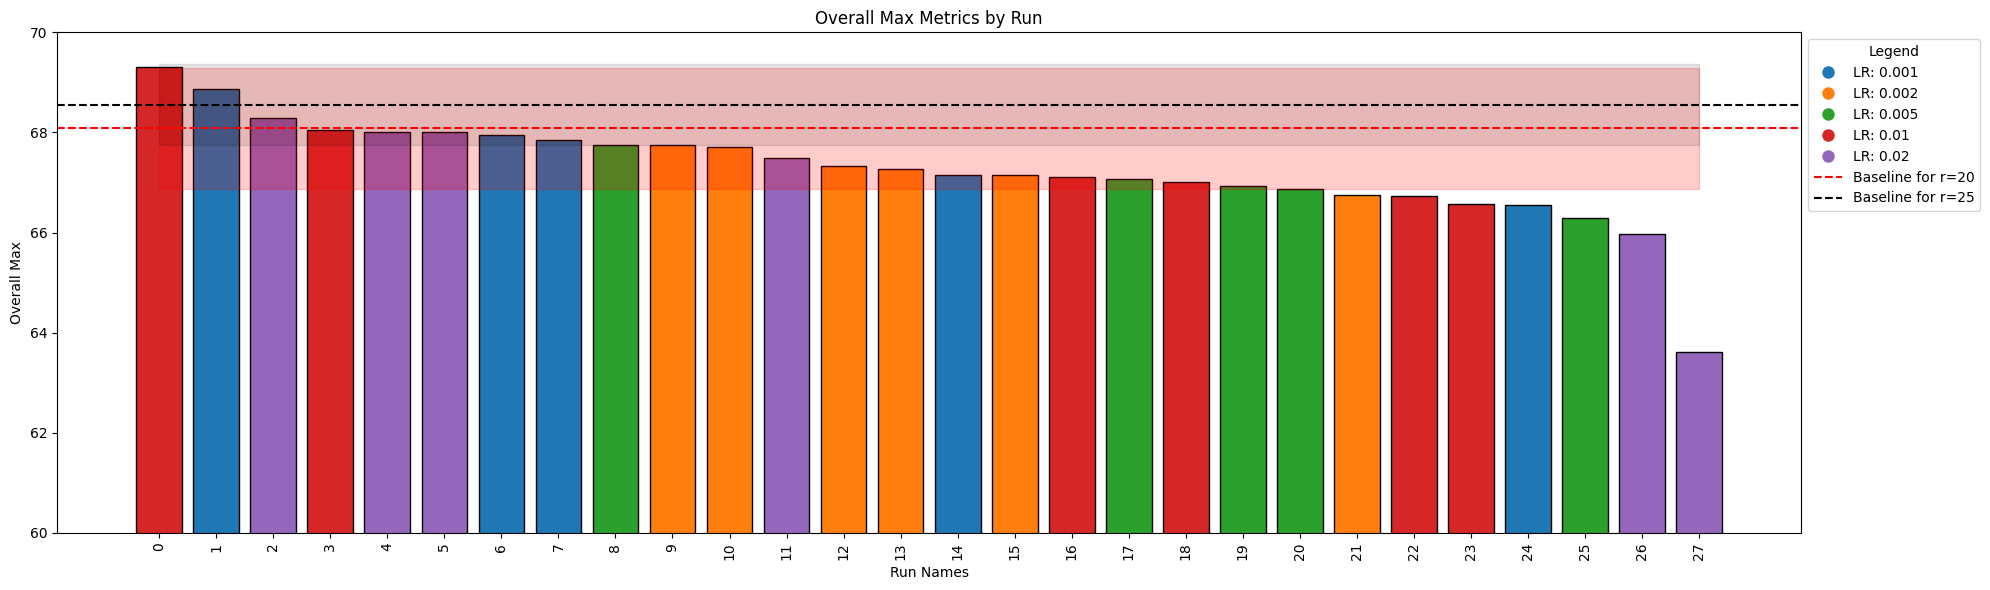

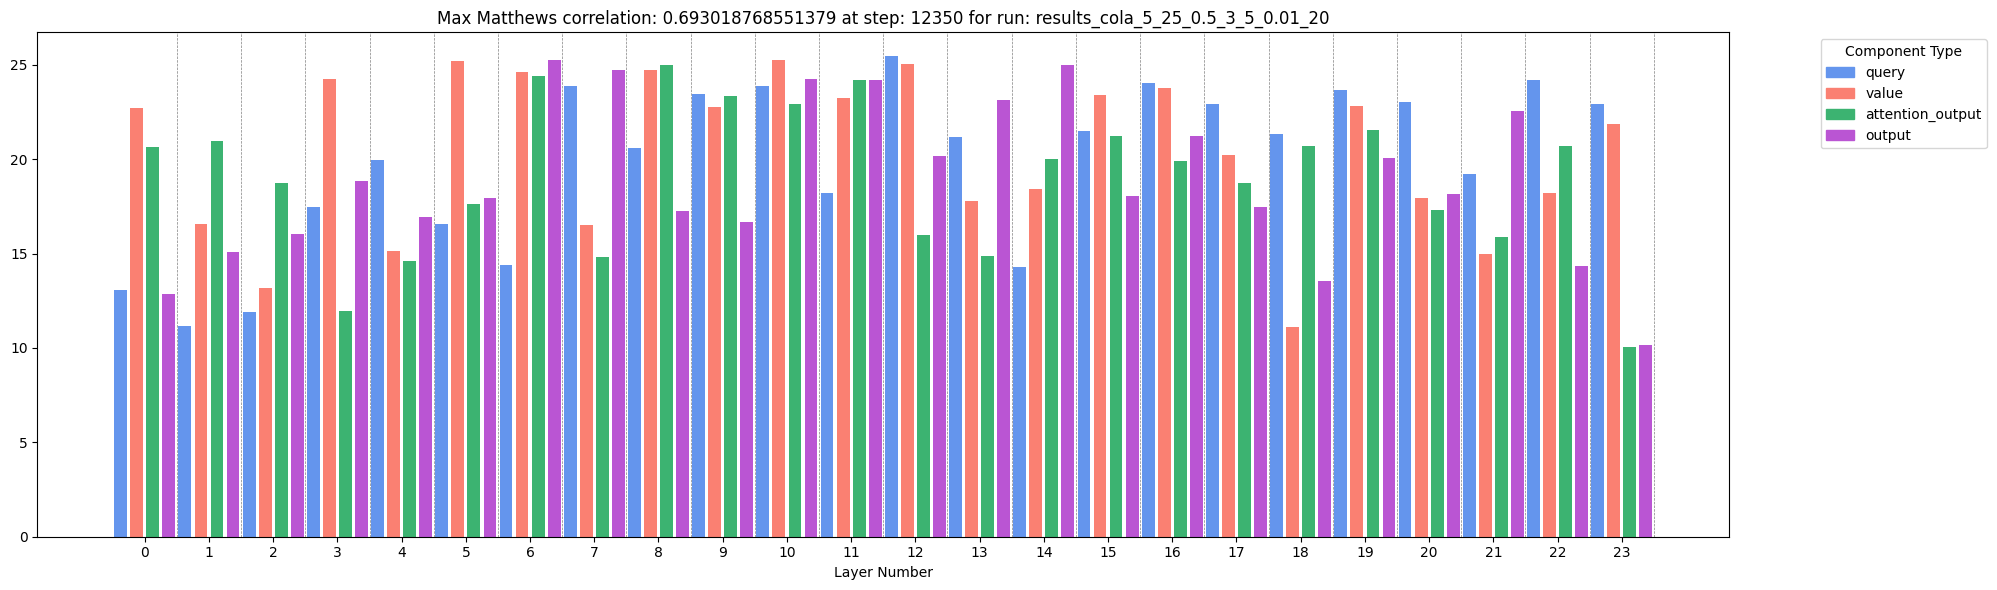

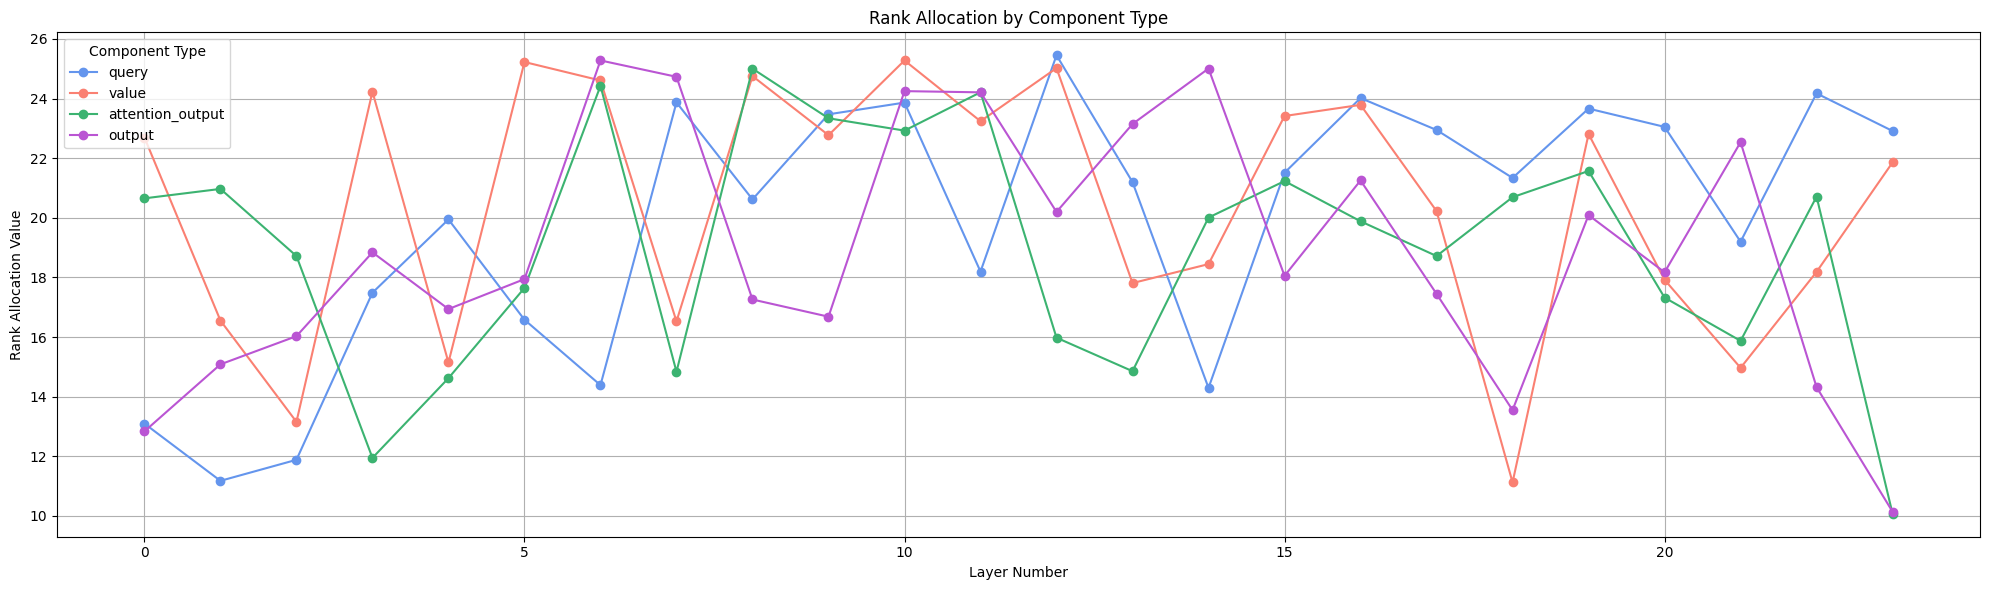

In [88]:
project = "adaptive_rank_allocation_l_r"
entity = "mallahova"
display_project_stats(project=project, entity=entity)

## Randn initialization

Baseline: 68.08 ± 1.21, Rank 25: 68.55 ± 0.81 - 
randn is **above the baseline** for LR=0.002 


| Task   |   Rank Min |   Rank Max |   Alpha Min |   Alpha Max |    LR |   Rank Avg | Median ± Std   |
|:-------|-----------:|-----------:|------------:|------------:|------:|-----------:|:---------------|
| cola   |          5 |         25 |         0.5 |           3 | 0.002 |         20 | 68.22 ± 1.05   |
| cola   |          5 |         25 |         0.5 |           3 | 0.01  |         20 | 67.60 ± 0.94   |
| cola   |          5 |         25 |         0.5 |           3 | 0.02  |         20 | 67.48 ± 0.85   |
| cola   |          5 |         25 |         0.5 |           3 | 0.005 |         20 | 66.94 ± 1.20   |
| cola   |          5 |         25 |         0.5 |           3 | 0.001 |         20 | 65.92 ± 0.80   |

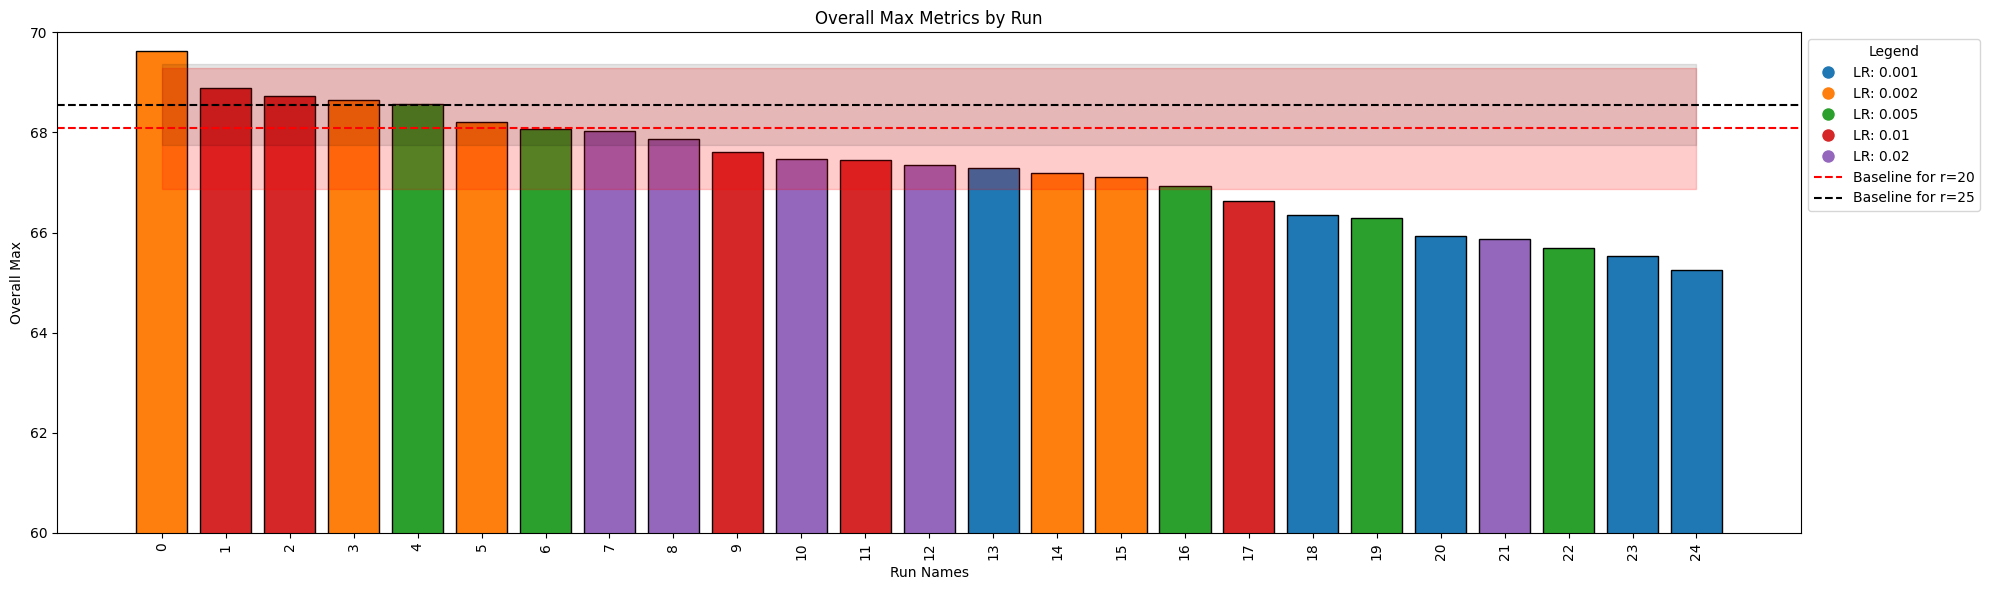

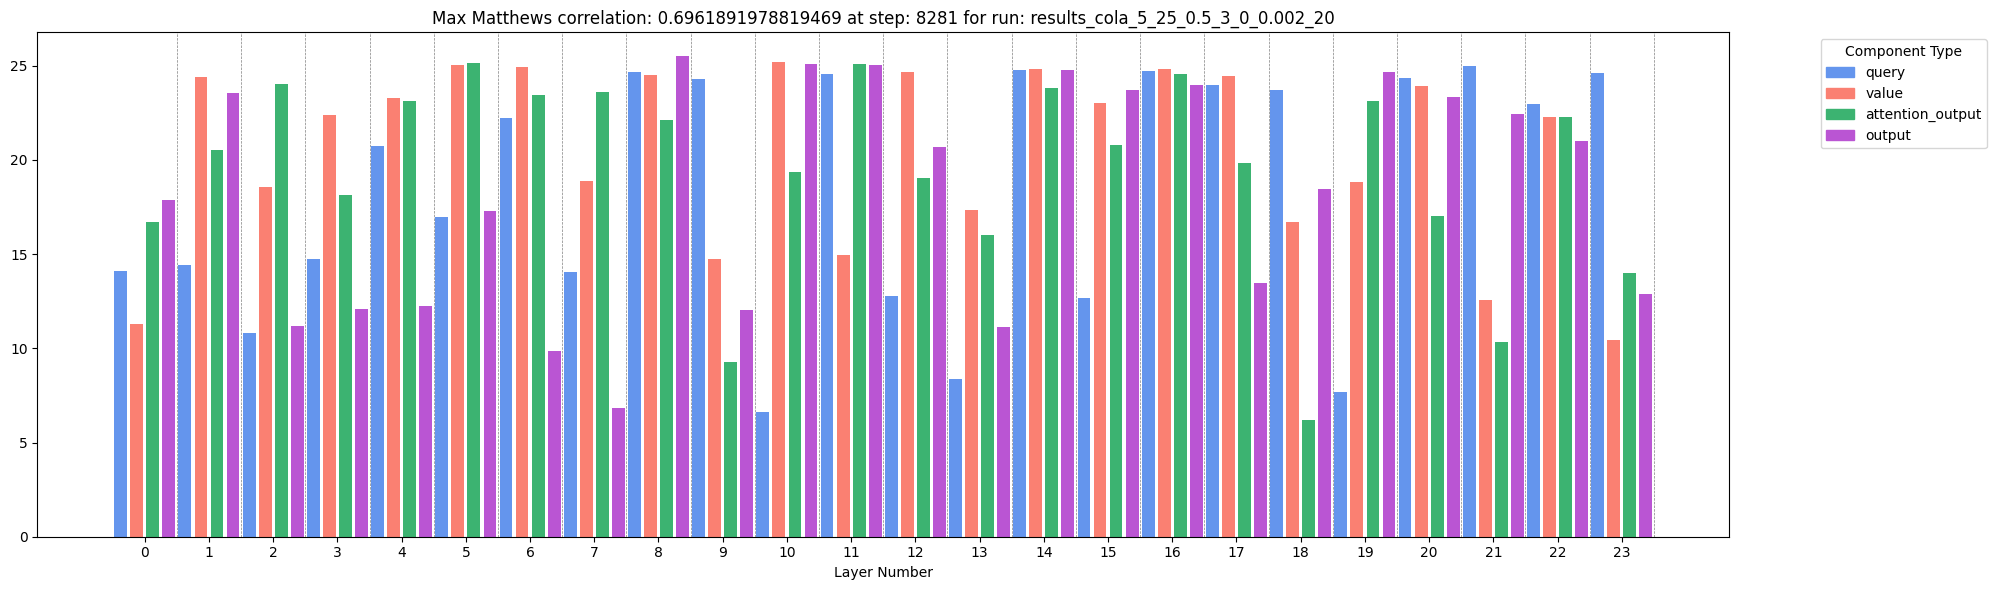

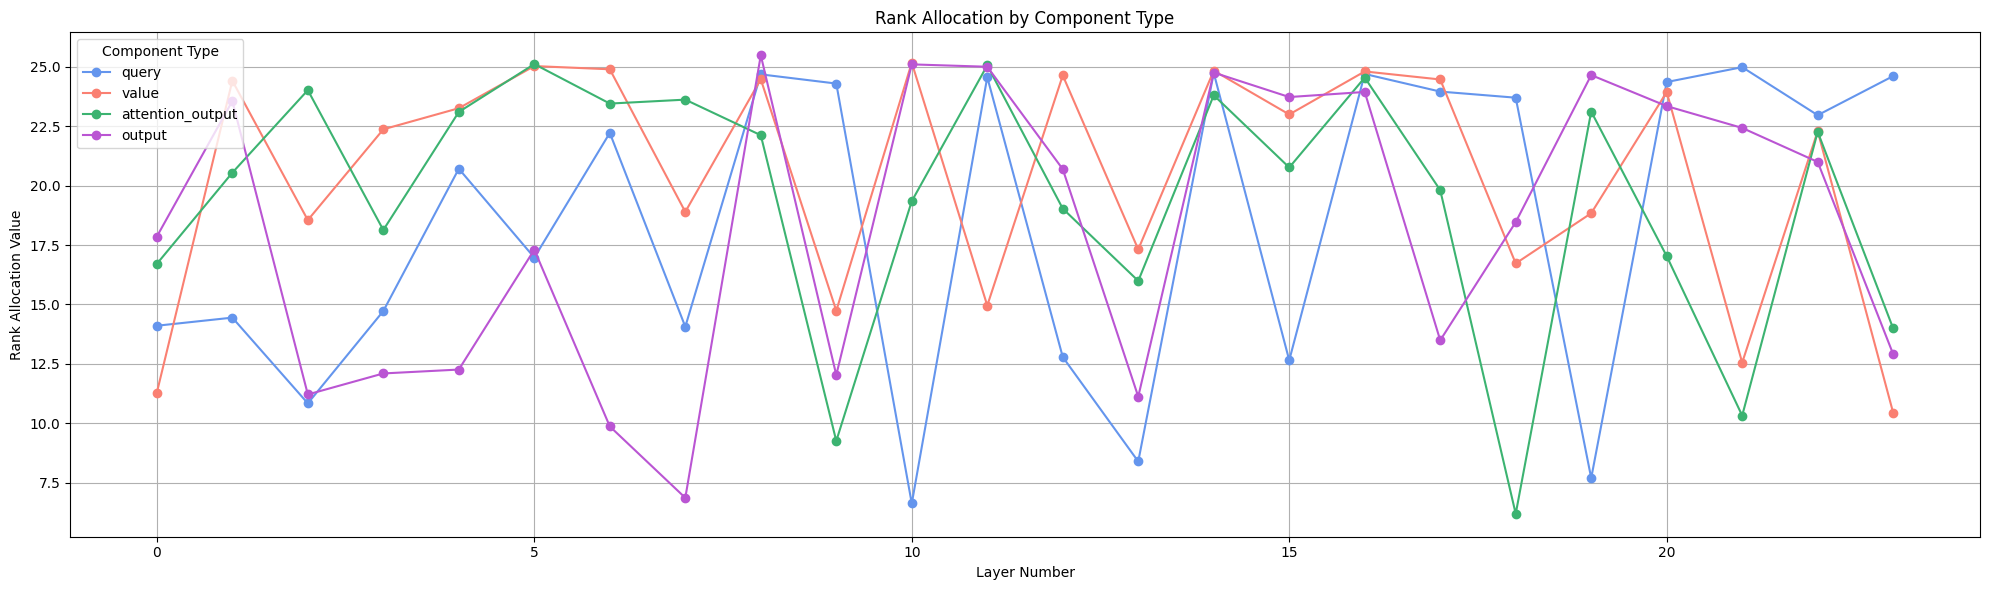

In [89]:
project = "adaptive_rank_allocation_random_init"
entity = "mallahova"
display_project_stats(project=project, entity=entity)

## Quadratic initialization

Baseline: 68.08 ± 1.21, Rank 25: 68.55 ± 0.81 - quadratic is slightly above the baseline


| Task   |   Rank Min |   Rank Max |   Alpha Min |   Alpha Max |    LR |   Rank Avg | Median ± Std   |
|:-------|-----------:|-----------:|------------:|------------:|------:|-----------:|:---------------|
| cola   |          5 |         25 |         0.5 |           3 | 0.02  |         20 | 68.13 ± 0.84   |
| cola   |          5 |         25 |         0.5 |           3 | 0.002 |         20 | 67.92 ± 0.46   |
| cola   |          5 |         25 |         0.5 |           3 | 0.01  |         20 | 67.10 ± 1.46   |
| cola   |          5 |         25 |         0.5 |           3 | 0.005 |         20 | 66.94 ± 1.20   |
| cola   |          5 |         25 |         0.5 |           3 | 0.001 |         20 | 65.92 ± 0.80   |

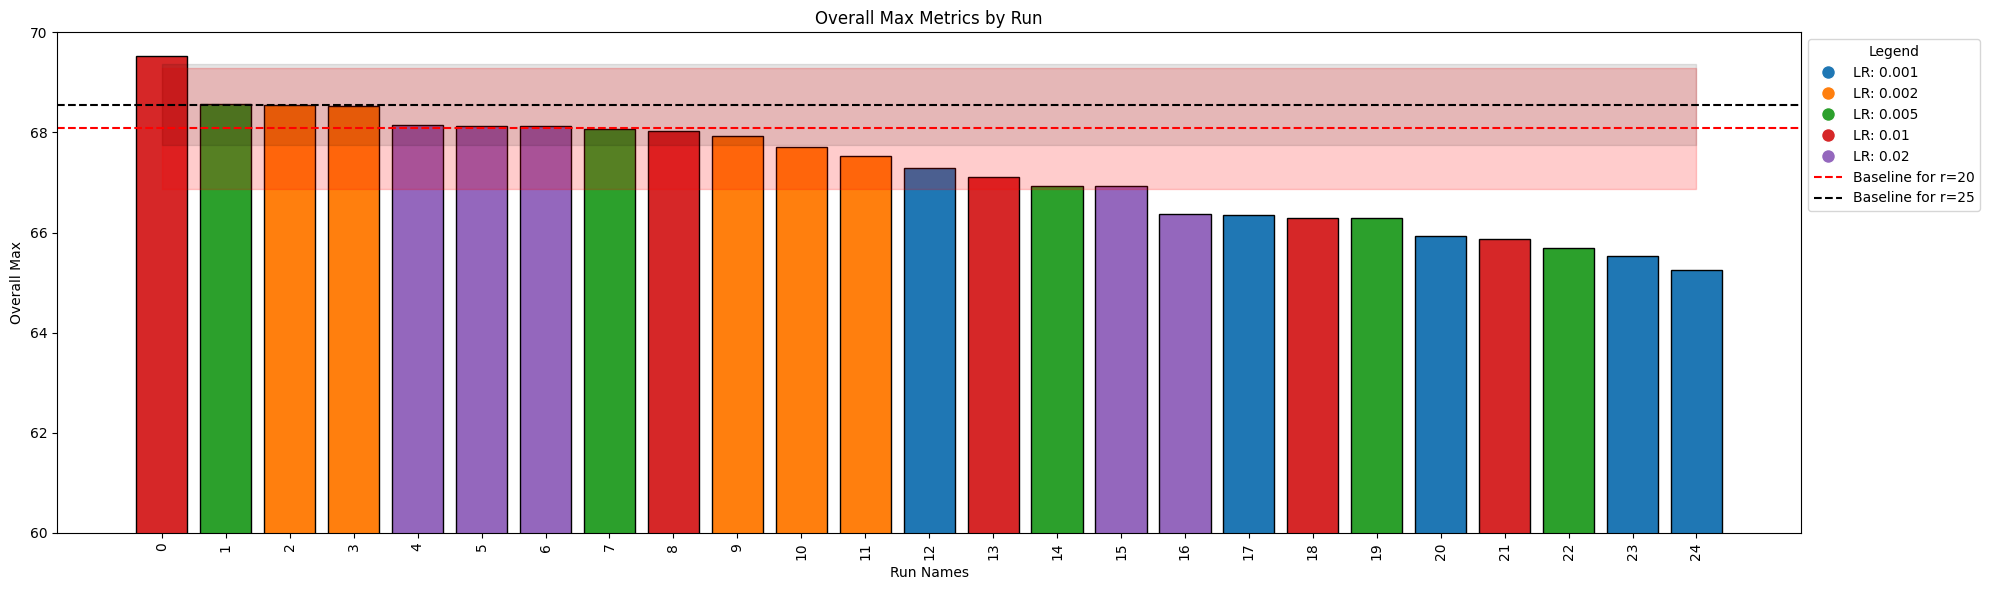

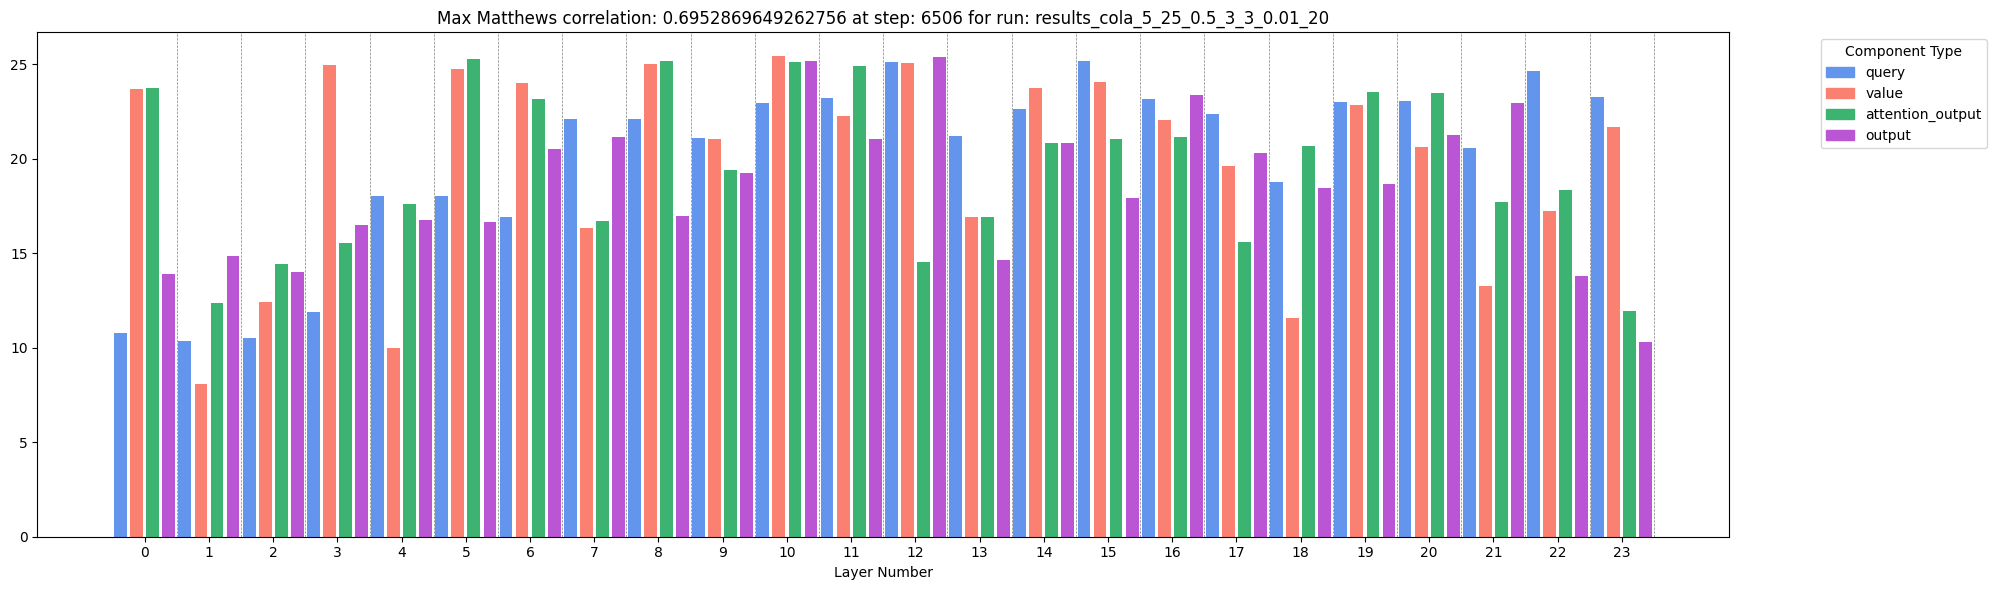

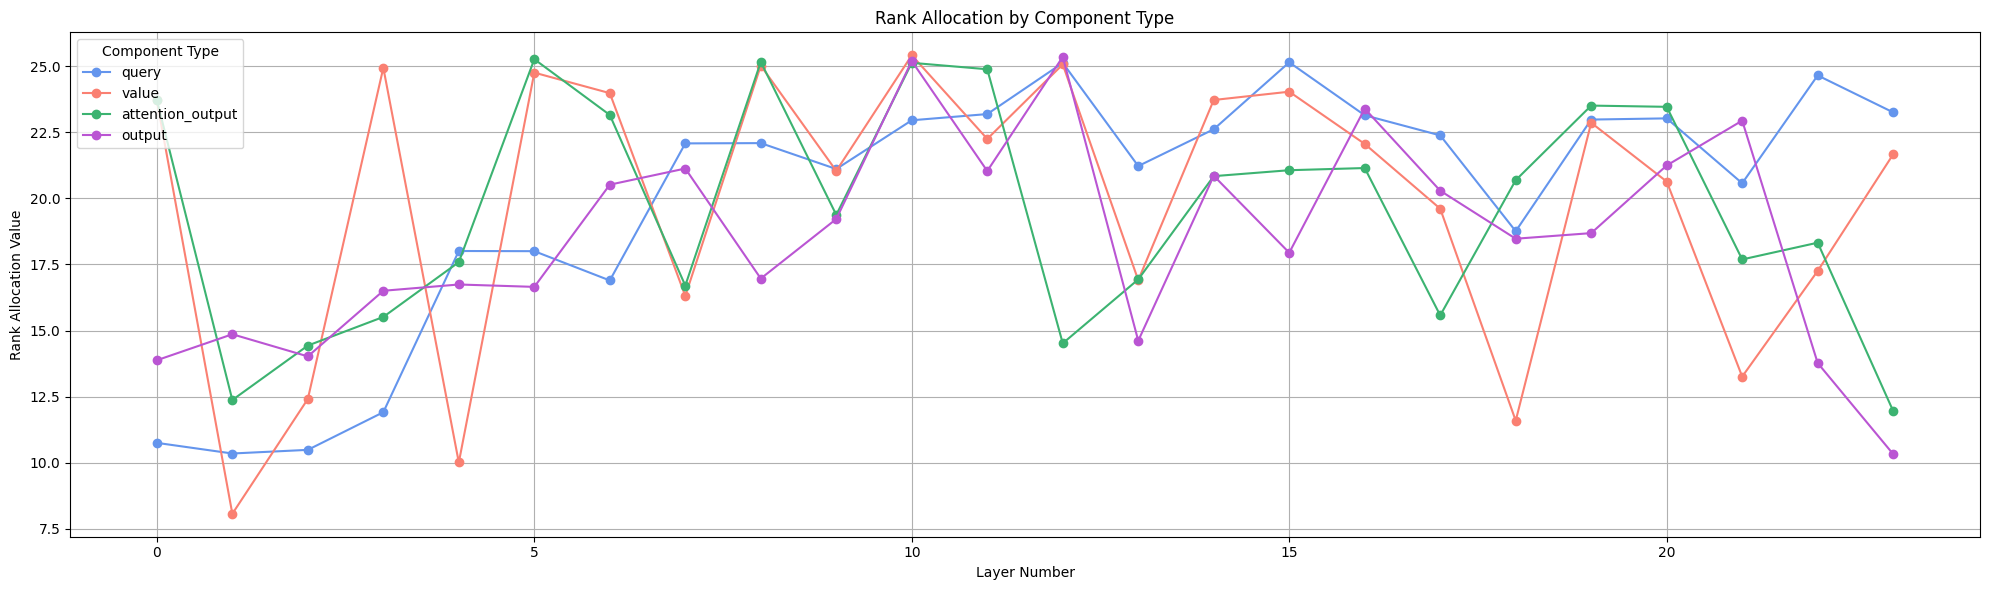

In [90]:
project = "adaptive_rank_allocation_quadratic_init"
entity = "mallahova" 
display_project_stats(project=project, entity=entity)

## Left skewed (centered at 3/4*n) initialization

Baseline: 68.08 ± 1.21, Rank 25: 68.55 ± 0.81 - left skewed is bellow the baseline

| Task   |   Rank Min |   Rank Max |   Alpha Min |   Alpha Max |    LR |   Rank Avg | Median ± Std   |
|:-------|-----------:|-----------:|------------:|------------:|------:|-----------:|:---------------|
| cola   |          5 |         25 |         0.5 |           3 | 0.005 |         20 | 67.78 ± 1.21   |
| cola   |          5 |         25 |         0.5 |           3 | 0.01  |         20 | 67.19 ± 2.00   |
| cola   |          5 |         25 |         0.5 |           3 | 0.001 |         20 | 67.16 ± 0.99   |
| cola   |          5 |         25 |         0.5 |           3 | 0.002 |         20 | 67.14 ± 0.92   |
| cola   |          5 |         25 |         0.5 |           3 | 0.02  |         20 | 65.56 ± 0.95   |

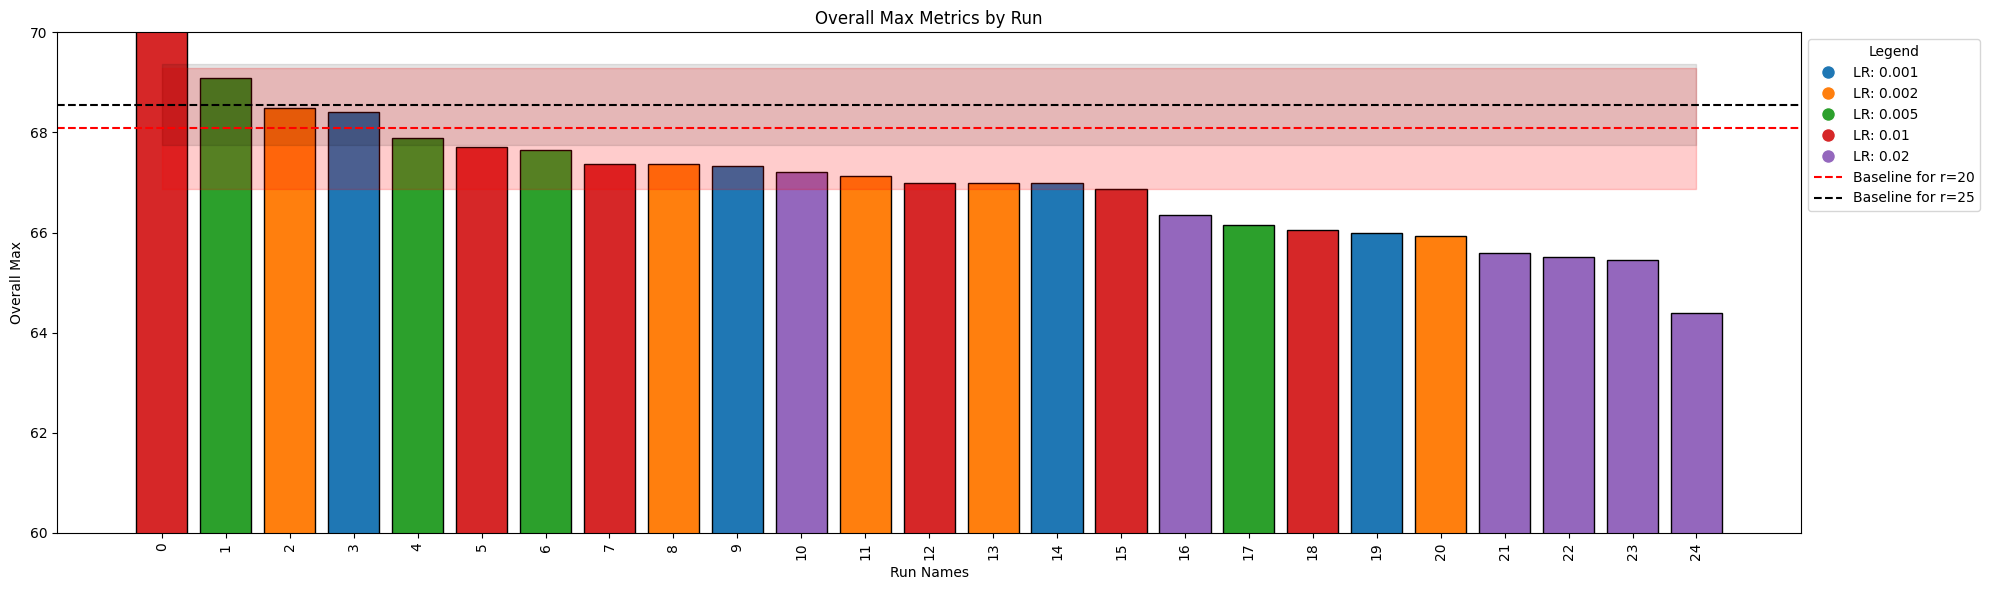

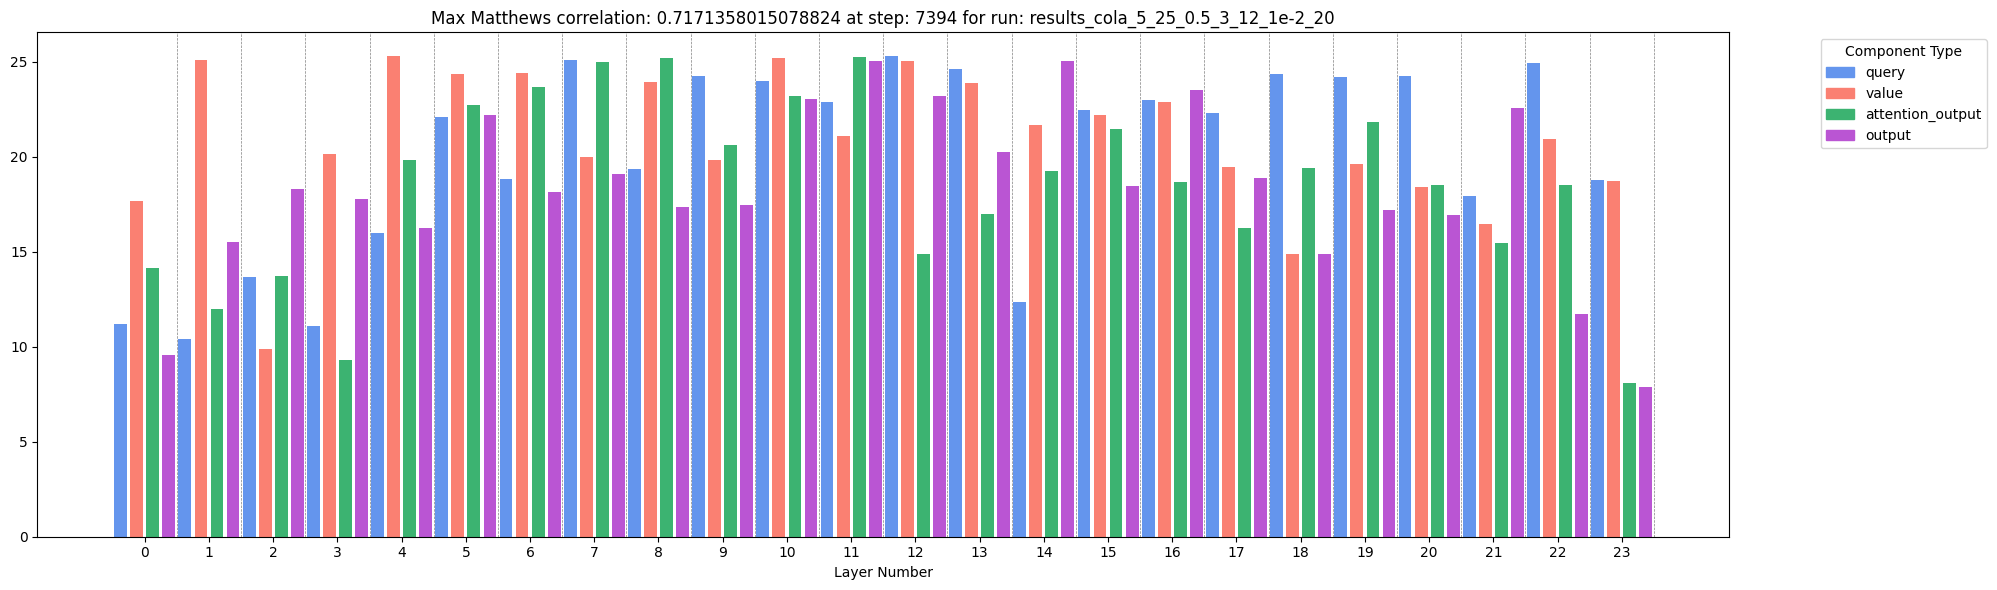

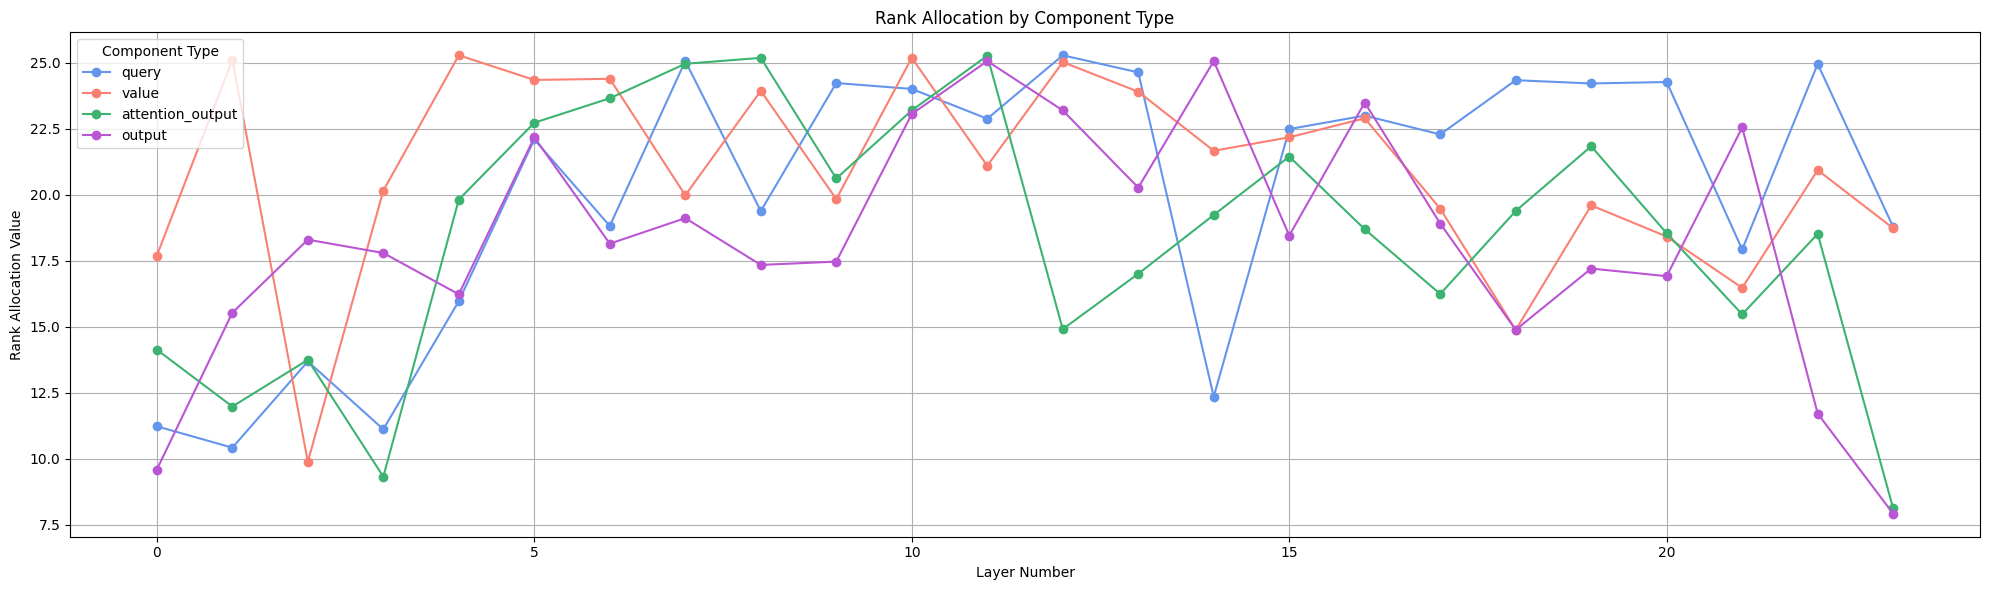

In [91]:
project = "adaptive_rank_allocation_left_skewed_init"
entity = "mallahova"
display_project_stats(project=project, entity=entity)

## Uniform, randn, quadratic, left-skewed comparison
Randn initialization has the best results.

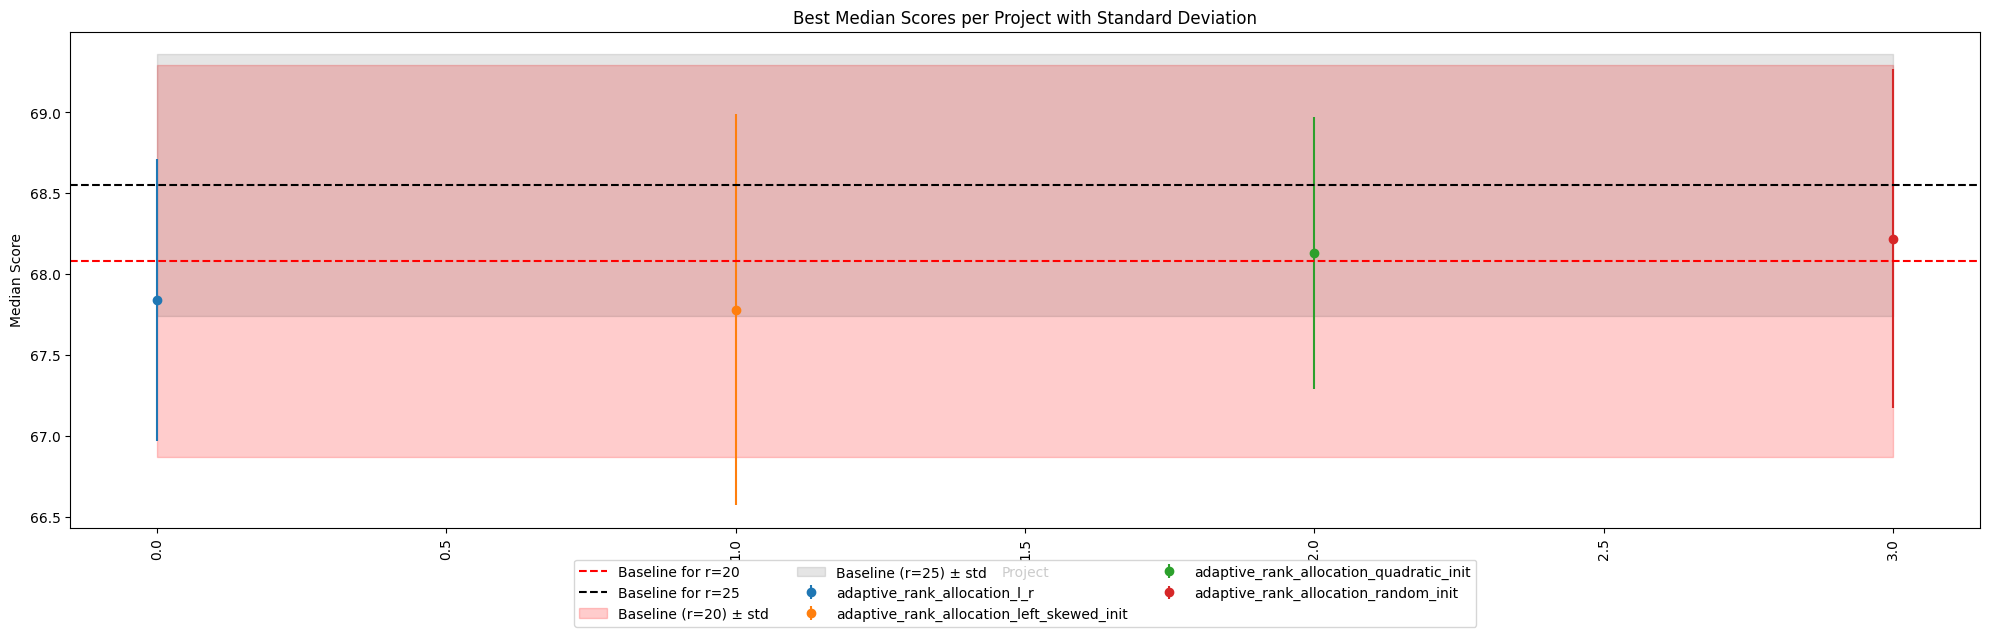

In [93]:
df = pd.read_csv("initializations_l_r_results.csv")

# Extract median and std from the "Median ± Std" column
def extract_median_std(value):
    match = re.match(r"([\d.]+) ± ([\d.]+)", str(value))
    if match:
        return float(match.group(1)), float(match.group(2))
    return None, None

df[["Median", "Std"]] = df["Median ± Std"].apply(lambda x: pd.Series(extract_median_std(x)))

# Get the best row (highest median) for each project
best_rows = df.loc[df.groupby("Project")["Median"].idxmax()]

# Plot
plt.figure(figsize=(20, 6))

# Plot each project with error bars for the best row (highest median)
for i, (_, row) in enumerate(best_rows.iterrows()):
    plt.errorbar(i, row["Median"], yerr=row["Std"], fmt='o', label=row["Project"])

# Baseline medians and stds
baseline_median = 68.08
baseline_std = 1.21
rank_25_median = 68.55
rank_25_std = 0.81

# Plot baseline lines
plt.axhline(baseline_median, color='red', linestyle='--', label='Baseline for r=20')
plt.axhline(rank_25_median, color='black', linestyle='--', label='Baseline for r=25')

# Calculate bar positions for filling shading around baselines
bar_positions = range(len(best_rows))  # Assuming `best_rows` is ordered by "Project" or similar

# Add shading for baselines with std
plt.fill_between(bar_positions, baseline_median - baseline_std, baseline_median + baseline_std, color='red', alpha=0.2, label='Baseline (r=20) ± std')
plt.fill_between(bar_positions, rank_25_median - rank_25_std, rank_25_median + rank_25_std, color='black', alpha=0.1, label='Baseline (r=25) ± std')

# Customize plot appearance
plt.xticks(rotation=90)
plt.xlabel("Project")
plt.ylabel("Median Score")
plt.title("Best Median Scores per Project with Standard Deviation")

# Remove y-tick labels (names for each point)

plt.tight_layout()

# Place the legend below the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)

# Show the plot
plt.show()


## Observations
At the beginning of the training (first 2 epochs), the ranks for first 33% of the layers are getting lower, while the ranks for 33% tend to get higher.

 <img src="assets/rank_allocation_beginning.png" alt=“LoRA-XS” width=90%>

## References
The visualization of each of the initializations is located at algorithm_visualization.ipynb
Results are located at initializations_l_r_results.csv

In [ ]:
project = "90_percent_memory_experiment"
entity = "mallahova"
run_max_metrics=get_results(project=project, entity=entity)
print_stats(run_max_metrics, project)
# plot_results(run_max_metrics)
# best_run = max(run_max_metrics, key=lambda x: x["overall_max"])
# plot_rank_allocation_by_component_type(values, component_types)
# # print_results(run_max_metrics)

| Task   |   Rank Min |   Rank Max |   Alpha Min |   Alpha Max |    LR |   Rank Avg | Median ± Std   |
|:-------|-----------:|-----------:|------------:|------------:|------:|-----------:|:---------------|
| cola   |          5 |         25 |         0.5 |           3 | 0.002 |         15 | 67.45 ± 0.43   |

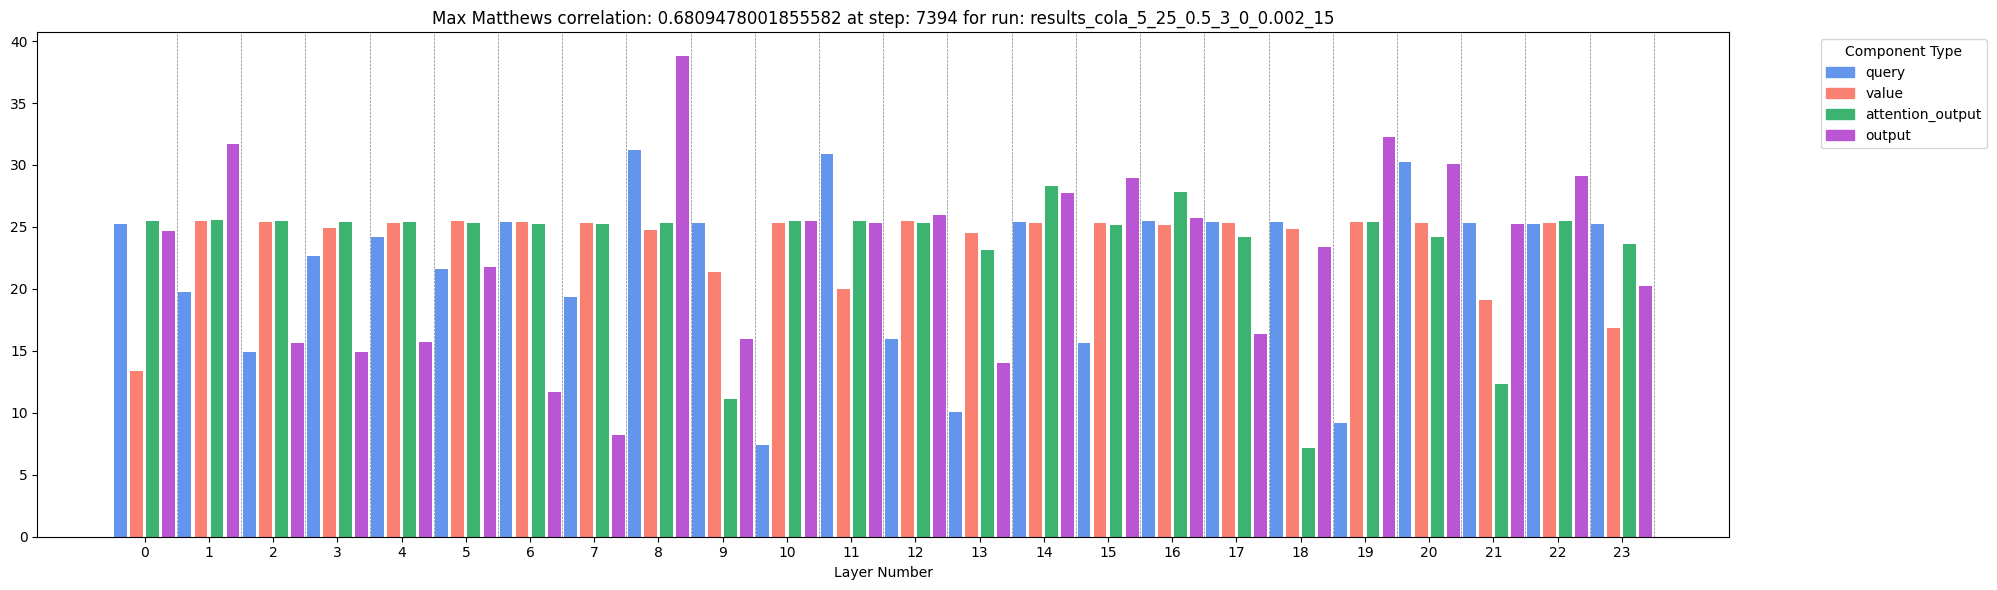

In [15]:

best_run = max(run_max_metrics, key=lambda x: x["overall_max"])
values, component_types=plot_rank_distribution(project=project, entity=entity, run_name=best_run['run_name'])


In [16]:

values.sum()/96

22.997903923193615

In [ ]:
def plot_rank_distribution(project: str, entity: str, run_name: str):
    # Load layer names from CSV
    layer_names_df = pd.read_csv('assets/layer_names.csv')
    
    # Parse component types and layer numbers from layer names
    component_types = []
    layer_nums = []
    for name in layer_names_df['Layer Name']:
        parts = name.split('encoder.layer.')
        after_encoder = parts[1].split('.')
        layer_num = int(after_encoder[0])
        layer_nums.append(layer_num)
        subparts = after_encoder[1:]
        if subparts[0] == 'attention':
            if subparts[1] == 'self':
                component = subparts[2]  # 'query' or 'value'
            elif subparts[1] == 'output':
                component = 'attention_output'
        elif subparts[0] == 'output':
            component = 'output'
        component_types.append(component)
    
    # Define colors for each component type
    component_colors = {
        'query': 'cornflowerblue',    # Muted blue
        'value': 'salmon',            # Soft orange
        'attention_output': 'mediumseagreen',  # Natural green
        'output': 'mediumorchid'      # Muted purple
    }
    
    # Fetch data from wandb
    api = wandb.Api()
    runs = api.runs(f"{entity}/{project}")
    run = next(run for run in runs if run.name == run_name)
    rank_metrics = "eval/matthews_correlation"
    keys = [rank_metrics, '_step']
    history = run.scan_history(keys=keys, page_size=1000)
    history_df = pd.DataFrame(history)
    
    max_correlation = history_df[rank_metrics].max()
    max_step = history_df.loc[history_df[rank_metrics].idxmax(), '_step']
    
    rank_allocation_keys = [f'train/rank_allocation_{i}' for i in range(0, 96)]
    step_data = run.scan_history(keys=['_step'] + rank_allocation_keys, page_size=1000)
    step_data_df = pd.DataFrame(step_data)
    step_values = step_data_df[(step_data_df['_step'] >= max_step - 3)]
    
    # Prepare data for plotting
    values = step_values[rank_allocation_keys].values[0]
    colors = [component_colors[ct] for ct in component_types]
    
    # Create the plot
    plt.figure(figsize=(20, 6))
    plt.bar(range(96), values, color=colors)
    
    # Add vertical lines to separate layers
    for i in range(24):
        x_pos = (i + 1) * 4 - 0.5
        plt.axvline(x=x_pos, color='gray', linestyle='--', linewidth=0.5)
    
    # Set x-ticks to layer numbers
    plt.xticks([i * 4 + 1.5 for i in range(24)], [str(i) for i in range(24)])
    plt.xlabel('Layer Number')
    
    # Create legend
    patches = [mpatches.Patch(color=color, label=label) for label, color in component_colors.items()]
    plt.legend(handles=patches, title='Component Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.title(f"Max Matthews correlation: {max_correlation} at step: {max_step} for run: {run_name}")
    plt.tight_layout()
    plt.show()
    return values, component_types